# Byzantine Fault Tolerant CRDTs

This is an implementation of the algorithm as specified in Martin Kleppmanns paper [Making CRDTs Byzantine fault tolerant](https://doi.org/10.1145/3517209.3524042).

## Implementation

Byzantine fault tolerance in this case means, that no byzantine node can change updates from other nodes or create invalid updates which could put nodes into an incorrect state. This is achieved by cryptographically signing updates. Each update is modelled as a triple $(v, h_p, h)$. $v$ is the delta value of the update, $h_p$ a set of hashes of the predecessors of this update and $h$ the hash of the update calculated from the value and the predecessor hashes. Predecessor hashes are all hashes that are known to a node at a specific time which 
    (1) are valid, meaning that their content and hash match and
    (2) are part of the known graph, meaning their respective predecessors are also known and valid.
A BFT CRDT (only called BFT in the following) is then comprised of a set of these updates which each contain a delta value. When two BFT nodes are merged, the resulting BFT contains all updates from each node which are also valid. Constructing a value out of a set of updates is achieved by first constructing a directional graph with updates as nodes and edges pointing to successors of each node. We call a node completely contained if all of its predecessors are known and valid. Starting at the root nodes (which have no further predecessors) we collect each completely contained successor. This is repeated for each newly collected node until all reachable completely contained nodes are found. The values of the collected nodes are then merged into the final value of the BFT.

## Performance

We benchmarked performance of the merge function using the JMH (Java Microbenchmark Harness). Each benchmark used a number of pregenerated deltas which are then merged. We measured performance for a `GrowOnlyCounter` and a `ReplicatedList` each in its normal form and then wrapped into a BFT.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

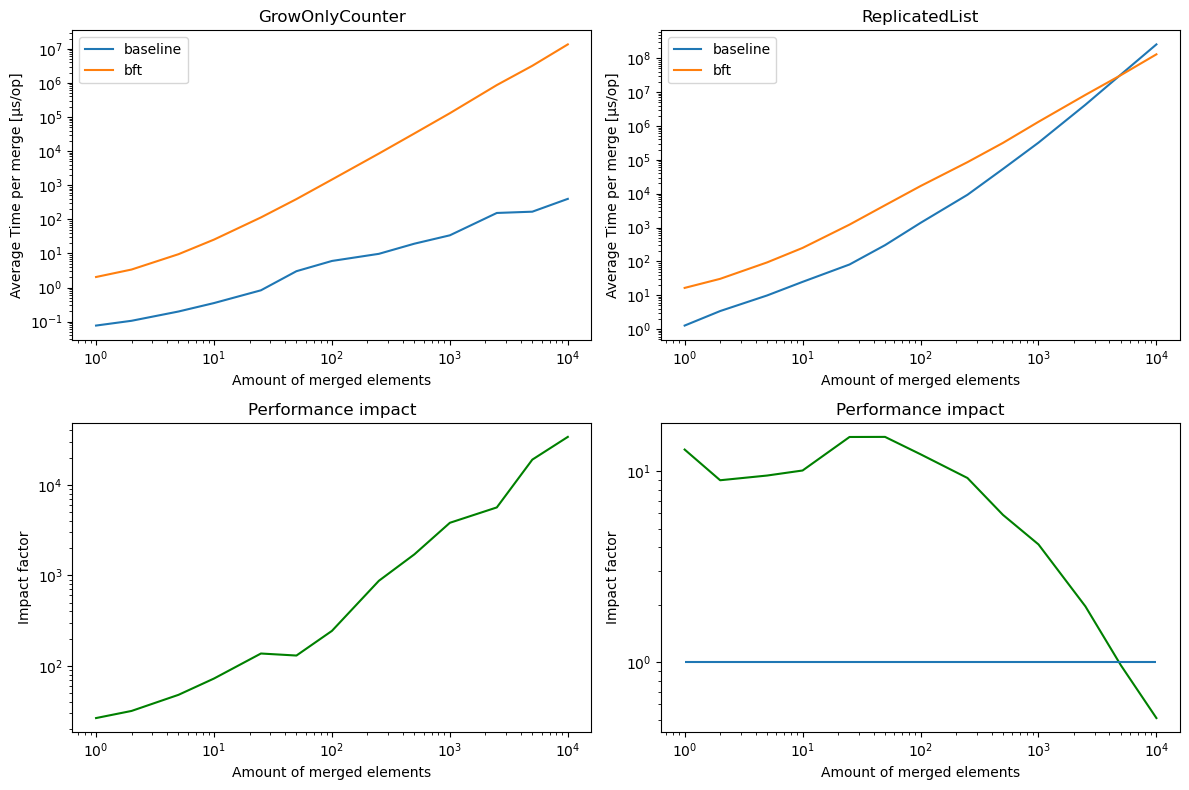

In [93]:
df = pd.read_csv("jmh-results.csv")

def datatype(row):
    if "GOC" in str(row["Benchmark"]):
        return "goc"
    else:
        return "replist"

def benchtype(row):
    if "baseline" in row["Benchmark"]:
        return "baseline"
    else:
        return "bft"

df['datatype'] = df.apply(datatype, axis=1)
df['benchtype'] = df.apply(benchtype, axis=1)
df = df.rename(columns={'Param: size': 'size'})

grouped = df.set_index(["datatype", "benchtype"])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

def plot_performance_data(axs, datatype, title):
    (ax1, ax2) = axs
    
    df[(df['datatype'] == datatype)].groupby(by='benchtype').plot(x="size", y="Score", kind="line", logx=True, logy=True, ax=ax1)
    
    ax1.set_title(title)
    ax1.legend(["baseline", "bft"])
    ax1.set_xlabel("Amount of merged elements")
    ax1.set_ylabel("Average Time per merge [µs/op]")

    dt = grouped.loc[datatype]

    sub = (dt.loc["bft"].set_index("size")["Score"] / dt.loc["baseline"].set_index("size")["Score"])
    sub.plot(ax=ax2, color='green', logx=True, logy=True)
    
    ax2.set_title("Performance impact")
#    ax2.legend(["Performance impact"])
    ax2.hlines(y=1, xmin=1, xmax=10000)
#    ax2.axhline(y=1)
    ax2.set_xlabel("Amount of merged elements")
    ax2.set_ylabel("Impact factor")

plot_performance_data((ax1, ax3), 'goc', "GrowOnlyCounter")
plot_performance_data((ax2, ax4), 'replist', "ReplicatedList")

fig.tight_layout()

The above figure shows log-log-plots for the benchmarked performance for `GrowOnlyCounter` and `ReplicatedList`. The upper plots show the performance characteristics of the benchmarked code in $\mu\text{s/op}$ for different amounts of deltas. The lower plots show performance impact, which is calculated as the factor the BFT implementation is slower than the baseline.

For the `GrowOnlyCounter` the bft performance is consistently slower than the baseline and performance becomes significantly worse and grows roughly exponential with a growing amount of deltas. For the `ReplicatedList` performance is roughly proportional with a slowdown of a factor of around 10 until about 100 deltas. Then the performance impact sharply drops until the BFT implementation even surpasses the baseline by roughly a factor of 2. We suspect, that the difference in performance between the datastructures is partly caused by the much greater complexity of the `ReplicatedList`. Especially the better performance of the BFT implementation compared to the baseline for the `ReplicatedList` though is currently unexplained and subject to future research.